1.Launch TensorFlow 1.x 

In [19]:
%tensorflow_version 1.x
import tensorflow as tf

print(tf.__version__)

1.15.2


In [2]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


**2. Clone and Build Darknet**

In [3]:
# clone darknet repo
!git clone https://github.com/AlexeyAB/darknet

Cloning into 'darknet'...
remote: Enumerating objects: 13781, done.
remote: Total 13781 (delta 0), reused 0 (delta 0), pack-reused 13781
Receiving objects: 100% (13781/13781), 12.36 MiB | 11.87 MiB/s, done.
Resolving deltas: 100% (9407/9407), done.


In [4]:
# change makefile to have GPU and OPENCV enabled
%cd darknet
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile

/content/darknet


In [5]:
# verify CUDA
!/usr/local/cuda/bin/nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243


In [6]:
# make darknet (build)
!make

mkdir -p ./obj/
mkdir -p backup
chmod +x *.sh
g++ -std=c++11 -std=c++11 -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv4 2> /dev/null || pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -DCUDNN -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -Ofast -DOPENCV -DGPU -DCUDNN -I/usr/local/cudnn/include -c ./src/image_opencv.cpp -o obj/image_opencv.o
./src/image_opencv.cpp: In function ‘void draw_detections_cv_v3(void**, detection*, int, float, char**, image**, int, int)’:
./src/image_opencv.cpp:910:23: warning: variable ‘rgb’ set but not used [-Wunused-but-set-variable]
                 float rgb[3];
                       ^~~
./src/image_opencv.cpp: In function ‘void cv_draw_object(image, float*, int, int, int*, float*, int*, int, char**)’:
./src/image_opencv.cpp:1391:14: warning: unused variable ‘buff’ [-Wunused-variable]
         char buff[100];
              ^~~~
./src/image_opencv.cpp:1367:9: warning: unused variable ‘it_tb_res’ [-W

**3. Download Pretrained YOLOv3 weights**

In [7]:
# get yolov3 pretrained coco dataset weights
!wget https://pjreddie.com/media/files/yolov3.weights

--2020-07-01 15:31:53--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights’

yolov3.weights      100%[===================>] 236.52M   180KB/s    in 23m 12s 

2020-07-01 15:55:07 (174 KB/s) - ‘yolov3.weights’ saved [248007048/248007048]



In [8]:
# define helper functions
def imShow(path):
  import cv2
  import matplotlib.pyplot as plt
  %matplotlib inline

  image = cv2.imread(path)
  height, width = image.shape[:2]
  resized_image = cv2.resize(image,(3*width, 3*height), interpolation = cv2.INTER_CUBIC)

  fig = plt.gcf()
  fig.set_size_inches(18, 10)
  plt.axis("off")
  plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
  plt.show()

# use this to upload files
def upload():
  from google.colab import files
  uploaded = files.upload() 
  for name, data in uploaded.items():
    with open(name, 'wb') as f:
      f.write(data)
      print ('saved file', name)

# use this to download a file  
def download(path):
  from google.colab import files
  files.download(path)

**4.Run detections with YOLO v3**

The pretraied weights of YOLO v3 are trained on 80 clases which can be found here http://cocodataset.org/#explore.



To run detection use the following command

```
!./darknet detect <path to config> <path to weights> <path to image>
```
OpenCV cant be openend in Google Colab. So we created the helper function imshow through matplotlib to display results here. 

To see the results here use the below code:


```
imShow('predictions.jpg')
```
This will output the image with the detections shown. The most recent detections are always saved to 'predictions.jpg'

*Note :* Darknet comes with a few images already installed in the darknet/data/ folder.



In [9]:
# run darknet detection
!./darknet detect cfg/yolov3.cfg yolov3.weights data/person.jpg

 CUDA-version: 10010 (10010), cuDNN: 7.6.5, GPU count: 1  
 OpenCV version: 3.2.0
 0 : compute_capability = 750, cudnn_half = 0, GPU: Tesla T4 
net.optimized_memory = 0 
mini_batch = 1, batch = 1, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   3 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   5 conv    128       3 x 3/ 2    208 x 208 x  64 ->  104 x 104 x 128 1.595 BF
   6 conv     64       1 x 1/ 1    104 x 104 x 128 ->  104 x 104 x  64 0.177 BF
   7 conv    128       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x 128 1.595 BF
   8 Shortcut Layer: 5,  wt = 0, wn = 0, outputs: 104 x 104 x 128 0.001 B

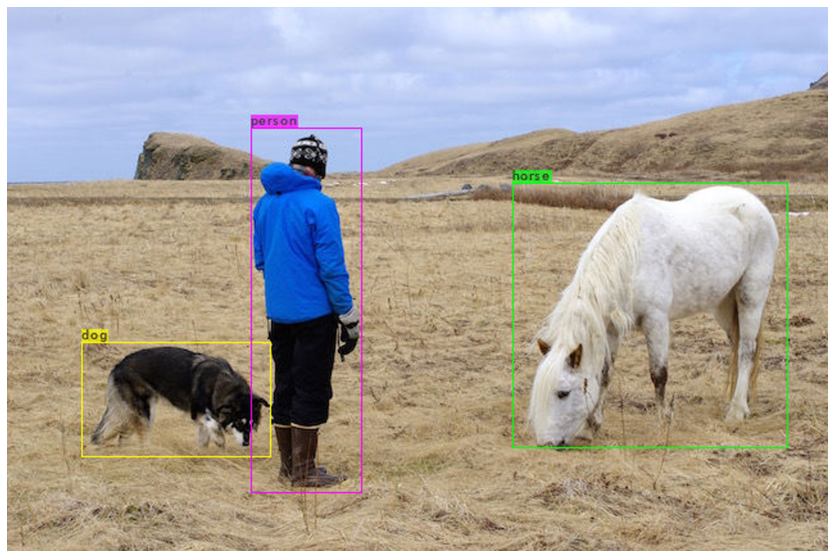

In [10]:
# show image using our helper function
imShow('predictions.jpg')

 CUDA-version: 10010 (10010), cuDNN: 7.6.5, GPU count: 1  
 OpenCV version: 3.2.0
 0 : compute_capability = 750, cudnn_half = 0, GPU: Tesla T4 
net.optimized_memory = 0 
mini_batch = 1, batch = 1, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   3 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   5 conv    128       3 x 3/ 2    208 x 208 x  64 ->  104 x 104 x 128 1.595 BF
   6 conv     64       1 x 1/ 1    104 x 104 x 128 ->  104 x 104 x  64 0.177 BF
   7 conv    128       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x 128 1.595 BF
   8 Shortcut Layer: 5,  wt = 0, wn = 0, outputs: 104 x 104 x 128 0.001 B

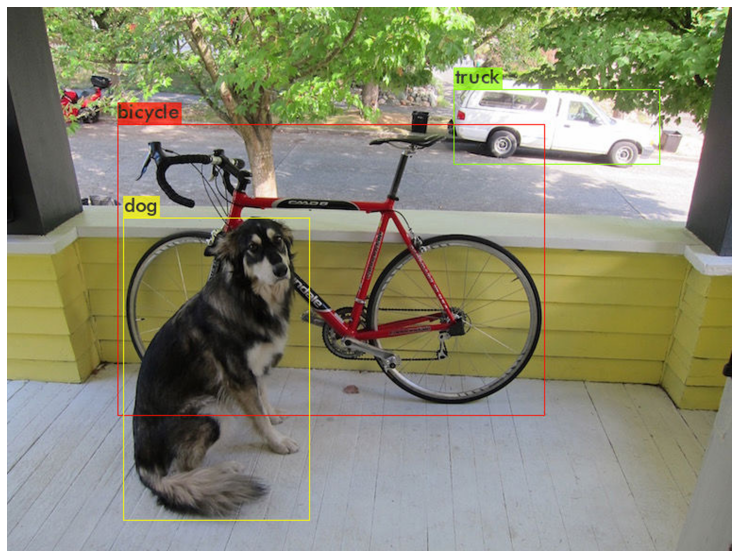

In [11]:
# look we can run another detection!
!./darknet detect cfg/yolov3.cfg yolov3.weights data/dog.jpg
imShow('predictions.jpg')

In [12]:
# This stops 'Run all' at this cell by causing an error
assert False

AssertionError: ignored

To download files

In [ ]:
# LOCAL MACHINE DOWNLOAD
# if you get an error first run then run it again and it should work
download('predictions.jpg')

In [ ]:
# GOOGLE DRIVE DOWNLOAD
# note that I can change what the image name is saved as (I am saving it as detection1.jpg)
!cp predictions.jpg /mydrive/images/detection1.jpg

**To connect to google drive**

In [ ]:
%cd ..
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
# this creates a symbolic link so that now the path /content/gdrive/My\ Drive/ is equal to /mydrive
!ln -s /content/gdrive/My\ Drive/ /mydrive
!ls /mydrive

In [ ]:
from google.colab import drive
drive.flush_and_unmount()

**6.Training a Custom YOLOv3 Object Detector in the Colab**

For custom YOLOv3 detector we need the following:

##

Labeled Custom Dataset

Custom .cfg file

obj.data and obj.names files

train.txt file 
##

**Step 1: Gathering and Labeling a Custom Dataset**


This can be done in two ways.

(1) using Google images or (2) creating your own dataset.

Method 1: Using Google's Open Images Dataset 

Get dataset from Google's Open Images Dataset (https://storage.googleapis.com/openimages/web/index.html) and use OIDv4 toolkit (https://github.com/EscVM/OIDv4_ToolKit) to generate labels.

Open OIDv4_ToolKit root folder and run the below in conda environment:

```
python main.py downloader --classes Bicycle Bicycle_helmet --type_csv train --limit 300 --multiclasses 1
```
creates a folder with 300 images for each.

Open OIDv4_ToolKit root folder and open the file classes.txt and edit it to have the classes you just downloaded,one per line .
##

Bicycle

Bicycle Helmet
##
Now convert the image annotations:


```
python convert_annotations.py
```
This converts all labels to YOLOv3 format which can now be used by darknet to properly train our custom object detector.

Method 2 :  Creating own dataset

You can download images from google by manually downloading or through web scrapping and Use the labelmg tool "https://github.com/tzutalin/labelImg" to label the images using the option YOLO format to download images in YOLO format. 


Zip all the data into a file obj.zip

**Step 2 : Custom Config file for Training and Testing** 

In the darknet cfg folder you will have yolov3.cfg file.

Copy that yolov3.cfg file and name it as custom_train and comment the testing and uncomment the training by keeping batch = 64 and subdivisions = 16.

Do the necessary changes like changing the number of class, filters ((5+classes)*3), max batches to 2000xclasses and steps to 80% and 90% of your max steps.

**Step 3 : Create obj.names and obj.data files**

You will need two file obj.names which will have all the classes.(you can copy the data in classes.txt to here)

In obj.data you need to write the required data for configuration.
looks like the below. 
###

classes =2

train = data/train.txt

valid = data/test.txt

names = data/obj.names

backup = backup/
###






**Step 4 : Uploading the files to Colab**


In [ ]:
import pathlib
pathlib.Path().absolute()

In [ ]:
import os
os.chdir('./darknet/data/')
import pathlib
pathlib.Path().absolute()

**Upload the obj.zip in darknet/data/**

In [ ]:
!ls

**Unzip that obj.zip file**

In [ ]:
%%shell

# extract it in the current folder
unzip obj.zip


**Place the obj.data and obj.names in /darknet/data folder and custom_train.cfg and custom_test.cfg files in /darknet/cfg folder.** 

In [ ]:
import os
os.chdir('/content/darknet/')
import pathlib
pathlib.Path().absolute()
!ls data/

Add the file train.py in /darknet/ and run below command to map all the files in obj.zip to data

In [ ]:
import os
os.chdir('/content/darknet/')
import pathlib
pathlib.Path().absolute()

In [ ]:
!python generate_train.py

In [ ]:
# verify train.txt can be seen in our darknet/data folder
!ls data/

**Step 5 : Download the pre-trainedweights from YOLO**

In [ ]:
import os
os.chdir('/content/darknet/')
import pathlib
pathlib.Path().absolute()

In [ ]:
# upload pretrained convolutional layer weights
!wget http://pjreddie.com/media/files/darknet53.conv.74

**Step 6 : Train the custom detector**

This training takes a while depending on the number of iterations you provide.


```
!./darknet detector train <path to obj.data> <path to custom config> darknet53.conv.74 -dont_show
```



In [ ]:
# train your custom detector
!./darknet detector train data/obj.data cfg/yolov3_custom_train.cfg darknet53.conv.74 -dont_show

**Step 7 : Check results on your custom tained weights**

You can directly use the custom_test.cfg file here to run the detection.

Also with the below commands you also modify the custom_train.cfg and use it for testing.

# 

```
# need to set our custom cfg to test mode 
%cd cfg
!sed -i 's/batch=64/batch=1/' yolov3_custom.cfg
!sed -i 's/subdivisions=16/subdivisions=1/' yolov3_custom.cfg
%cd ..

```



 CUDA-version: 10010 (10010), cuDNN: 7.6.5, GPU count: 1  
 OpenCV version: 3.2.0
 0 : compute_capability = 750, cudnn_half = 0, GPU: Tesla T4 
net.optimized_memory = 0 
mini_batch = 1, batch = 1, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   3 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   5 conv    128       3 x 3/ 2    208 x 208 x  64 ->  104 x 104 x 128 1.595 BF
   6 conv     64       1 x 1/ 1    104 x 104 x 128 ->  104 x 104 x  64 0.177 BF
   7 conv    128       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x 128 1.595 BF
   8 Shortcut Layer: 5,  wt = 0, wn = 0, outputs: 104 x 104 x 128 0.001 B

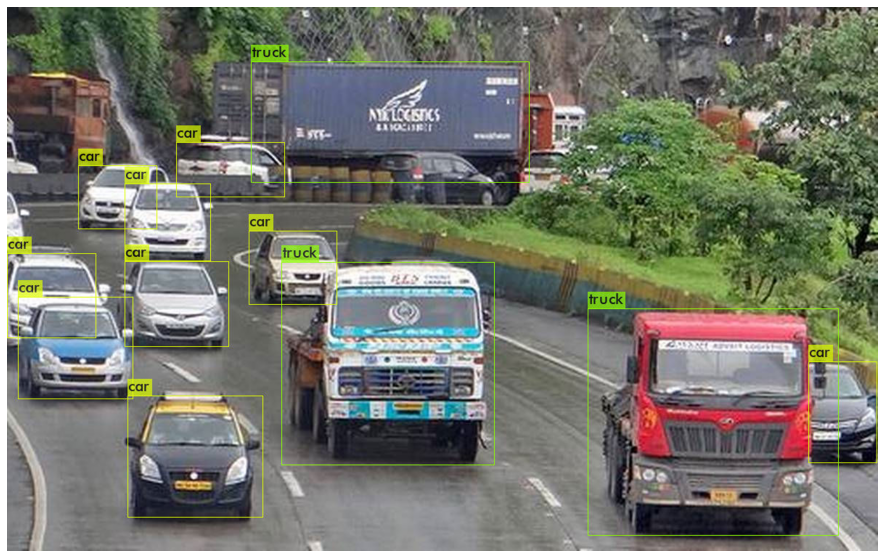

In [16]:
# run your custom detector with this command 
!./darknet detect cfg/yolov3_custom_test.cfg /backup/yolov3_custom_last.weights 2.jpg -thresh 0.7
imShow('predictions.jpg')

# **      Thank You**